In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_model
from kgcnn.data.utils import ragged_tensor_from_nested_numpy
from kgcnn.training.scheduler import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.MutagenicityDataset import MutagenicityDataset

## Load data

In [2]:
dataset = MutagenicityDataset()
labels, nodes, edge_indices, edges, atoms = [dataset.obtain_property(prop) for prop in ["graph_labels", "node_attributes", "edge_indices", "edge_attributes", "node_number"]]
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32) # Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype="int") # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name Mutagenicity
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.Mutagenicity:Reading dataset to memory with name Mutagenicity
INFO:kgcnn.data.Mutagenicity:Shift start of graph ID to zero for 'Mutagenicity' to match python indexing.
INFO:kgcnn.data.Mutagenicity:Graph index which has unconnected '[  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 26

[TensorShape([3469, None, 14]), TensorShape([3469, None, 1]), TensorShape([3469, None, 2])]
[TensorShape([868, None, 14]), TensorShape([868, None, 1]), TensorShape([868, None, 2])]
(3469, 1, 1) (868, 1, 1)


## Make and train GCN

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'GCN', 'inputs': [{'shape': (None, 14), 'name': 'node_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 1), 'name': 'edge_attributes', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}], 'input_embedding': {'node': {'input_dim': 55, 'output_dim': 64}, 'edge': {'input_dim': 10, 'output_dim': 64}}, 'gcn_args': {'units': 64, 'use_bias': True, 'activation': 'relu', 'pooling_method': 'mean', 'is_sorted': False, 'has_unconnected': True}, 'depth': 3, 'verbose': 1, 'output_embedding': 'graph', 'output_to_tensor': True, 'output_mlp': {'use_bias': [True, True, False], 'units': [140, 70, 1], 'activation': ['relu', 'relu', 'sigmoid']}}


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_attributes (InputLayer)   [(None, None, 14)]   0           []                               
                                                                                                  
 optional_input_embedding (Opti  (None, None, 14)    0           ['node_attributes[0][0]']        
 onalInputEmbedding)                                                                              
                                                                                                  
 edge_attributes (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 dense_embedding (DenseEmbeddin  (None, None, 64)    960         ['optional_input_embedding[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSli

109/109 - 3s - loss: 0.6509 - accuracy: 0.6178 - lr: 0.0010 - 3s/epoch - 29ms/step
Epoch 2/150
109/109 - 1s - loss: 0.6153 - accuracy: 0.6786 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 3/150
109/109 - 1s - loss: 0.5951 - accuracy: 0.6979 - lr: 0.0010 - 1s/epoch - 13ms/step
Epoch 4/150
109/109 - 1s - loss: 0.5652 - accuracy: 0.7091 - lr: 0.0010 - 1s/epoch - 13ms/step
Epoch 5/150
109/109 - 1s - loss: 0.5610 - accuracy: 0.7244 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 6/150
109/109 - 1s - loss: 0.5388 - accuracy: 0.7308 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 7/150
109/109 - 1s - loss: 0.5383 - accuracy: 0.7276 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 8/150
109/109 - 2s - loss: 0.5302 - accuracy: 0.7394 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 9/150
109/109 - 2s - loss: 0.5125 - accuracy: 0.7553 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 10/150
109/109 - 2s - loss: 0.5105 - accuracy: 0.7501 - val_loss: 0.5532 - val_accuracy: 0.7327 - lr: 0.0010 - 2s/epoch - 21ms/step
Epoch 11/150
109/10

109/109 - 2s - loss: 0.2862 - accuracy: 0.8789 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 84/150
109/109 - 1s - loss: 0.2898 - accuracy: 0.8778 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 85/150
109/109 - 1s - loss: 0.2883 - accuracy: 0.8709 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 86/150
109/109 - 1s - loss: 0.2750 - accuracy: 0.8821 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 87/150
109/109 - 1s - loss: 0.2807 - accuracy: 0.8775 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 88/150
109/109 - 1s - loss: 0.2746 - accuracy: 0.8809 - lr: 0.0010 - 1s/epoch - 14ms/step
Epoch 89/150
109/109 - 2s - loss: 0.2881 - accuracy: 0.8740 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 90/150
109/109 - 2s - loss: 0.2708 - accuracy: 0.8890 - val_loss: 0.5544 - val_accuracy: 0.7776 - lr: 0.0010 - 2s/epoch - 18ms/step
Epoch 91/150
109/109 - 2s - loss: 0.2725 - accuracy: 0.8847 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 92/150
109/109 - 2s - loss: 0.2588 - accuracy: 0.8890 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 93/15

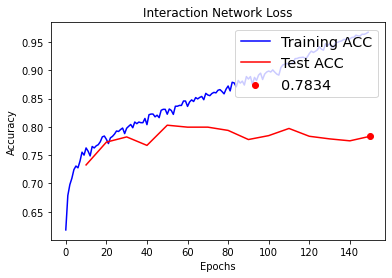

In [3]:
model_args = {'name': "GCN",
                 'inputs': [{'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 55, "output_dim": 64},
                                     "edge": {"input_dim": 10, "output_dim": 64}},
                 'output_embedding': 'graph',
                 'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                                "activation": ['relu', 'relu', 'sigmoid']},
                 'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean'},
                 'depth': 3, 'verbose': 1
              }
model = make_model(**model_args)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_3.png')
plt.show()

## Implement the ExplainableGNN from GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        return self.gnn_model(gnn_input, training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = tf.ragged.map_flat_values(tf.math.multiply, edge_input, edge_mask)
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        masked_node_feature_input = tf.ragged.map_flat_values(tf.math.multiply, masked_feature_input, node_mask)
        masked_pred = \
        self.gnn_model([masked_node_feature_input, masked_edge_input, edge_index_input], training=training)[0]

        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

Instanciate a Explainable GNN:

In [5]:
explainable_gcn = ExplainableGCN(model)
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.2)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.001,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

inspection_result = explainer.explain([tensor[776:777] for tensor in xtest], inspection=True)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


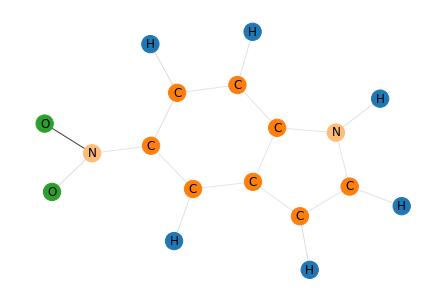

In [6]:
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)

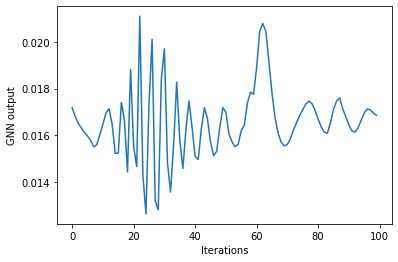

In [7]:
# Plot predicion
plt.figure()
plt.plot(inspection_result['predictions'])
plt.xlabel('Iterations')
plt.ylabel('GNN output')
plt.show()

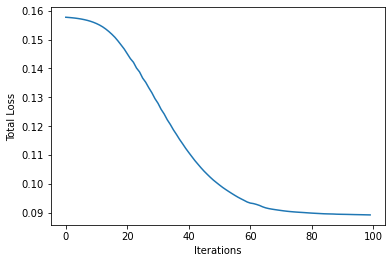

In [8]:
# PLot loss
plt.figure()
plt.plot(inspection_result['total_loss'])
plt.xlabel('Iterations')
plt.ylabel('Total Loss')
plt.show()

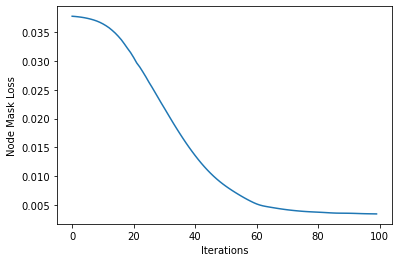

In [9]:
# Plot Edge Mask loss
plt.figure()
plt.plot(inspection_result['edge_mask_loss'])
plt.xlabel('Iterations')
plt.ylabel('Node Mask Loss')
plt.show()

sample 200 mutagenic molecules:

In [10]:
pred = model.predict(xtest)[:,0]
sampled_mutagenic_molecules = np.random.choice(np.argwhere(pred < 0.5)[:,0], 200)
print(sampled_mutagenic_molecules)

28/28 [==============================] - 1s 8ms/step
[313  44  99 400 746 687  26 789 631 287 660 848 718 176   0 599 578 652
 413 299 765 212 348  49 652 524 472  49 173 316 133 602 803 104 850 696
  90  41 545 696  48 100 527 839 108 773 709 409 737 348  72 400 189 516
 381 777 381 117 847 190 575 619 243 262 376 425  83 226 767 430 819 698
 103 300 517 358 258 230 628 755 412 218 743 391 746 663 611 765  33 251
 352 403 343 830 409 578 791 306 103 352 288 757 830 627 670 578 119 648
 767 746 452 750 840 671 272 172 165 443 749 421 298 251 602 258 168 177
 190 100 704 509 532 503  51 379 382 685 836 310 650 500 358  87  26 205
 791 400 299 565  59 343 502 737 350  45 396 412 372 109 116 568 407 352
 394 809 168 427 297 402 579  53 421 800 552 422 137 561 166 250 739 760
  10 272 158  20 690 333 650 585 153 570 730 402 489 798 309  64 670  63
 118 760]


Generate explanations for all those 50 molecules (this will take a while):

In [11]:
explanations = []
for i,mol_index in enumerate(sampled_mutagenic_molecules):
    explainer.explain([tensor[mol_index:mol_index+1] for tensor in xtest])
    print(i, end=',')
    explanations.append(explainer.get_explanation())

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,

We transform the explanation graphs to vectors, in order to apply a cluster algorithm on the explanation vectors:

In [12]:
def explanation_to_vector(explanation):
    graph = explanation[0]
    bond_matrix = np.zeros((14,14))
    for (u, v, relevance) in graph.edges.data('relevance'):
        atom1 = np.argwhere(graph.nodes[u]['features']==1)[0]
        atom2 = np.argwhere(graph.nodes[v]['features']==1)[0]
        bond_matrix[atom1, atom2] += relevance
        bond_matrix[atom2, atom1] += relevance
    bond_vector = bond_matrix[np.triu_indices(bond_matrix.shape[0])]
    bond_vector = bond_vector / np.sum(bond_vector)
    return bond_vector
explanation_vectors = [explanation_to_vector(expl) for expl in explanations]

a dendogram of the explanation vectors:

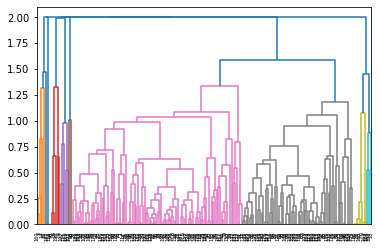

In [13]:
plt.figure()
linked = linkage(explanation_vectors, 'complete', metric='cityblock')
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

Print one representative graph explanation for each cluster:

(168, 105)


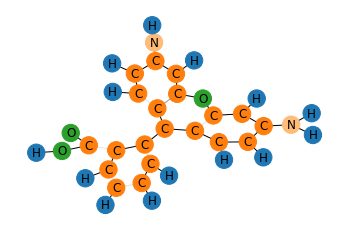

(11, 105)


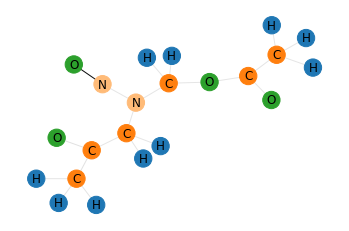

(6, 105)


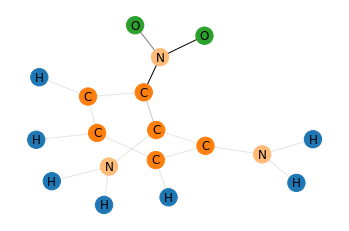

(2, 105)


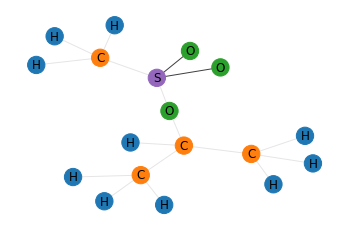

(6, 105)


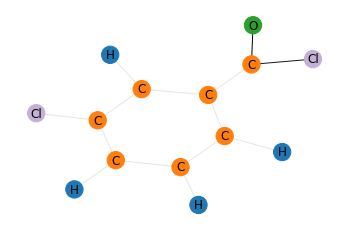

(2, 105)


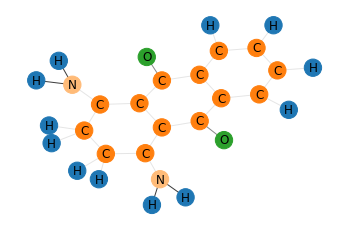

(5, 105)


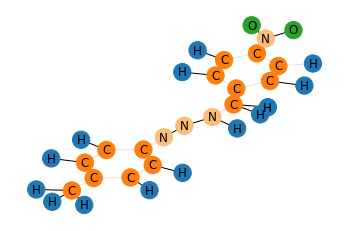

In [14]:
num_clusters = 7
db = AgglomerativeClustering(n_clusters=num_clusters, affinity='manhattan', linkage='complete').fit(explanation_vectors)
vector_clusters = []
explanation_clusters = []
for cluster_ind in range(num_clusters):
    plt.figure()
    vector_cluster = np.array([explanation_vectors[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]])
    vector_clusters.append(vector_cluster)
    explanation_cluster = [explanations[i] for i in np.argwhere(db.labels_ == cluster_ind)[:,0]]
    explanation_clusters.append(explanation_cluster)
    cluster_mean = np.mean(vector_cluster, axis=0)
    dist = cdist(np.array([cluster_mean]), vector_cluster)[0]
    print(vector_cluster.shape)
    ax = plt.subplot()
    explainer.present_explanation(explanation_cluster[np.argmin(dist)])
    plt.show()